## Batch correction titration experiments

In [2]:
from pathlib import Path
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# set results directory
base_results_dir = Path(cfg.results_dirs['mutation'],
                        'bc_titration')

# which gene to plot
# plot_genes = ['TP53', 'KRAS', 'EGFR', 'IDH1', 'SETD2', 'PIK3CA']
plot_genes = ['EGFR']

# how many features to plot, 1000 or 5000
# plot_feats = 1000
plot_feats = 1000

In [48]:
def load_single_model(results_file):
    results_filename = Path(results_file).stem
    if results_filename[0] == '.':
        return pd.DataFrame()
    if ('classify' not in results_filename or 
        'metrics' not in results_filename):
        return pd.DataFrame()
    titration_ratio = float(results_filename.split('_')[5].replace('t', ''))
    results_df = pd.read_csv(results_file, sep='\t')
    results_df['titration_ratio'] = titration_ratio
    return results_df
    
def load_all_models(base_results_dir, genes, num_feats):
    models = ['linear_bc', 'nonlinear_bc']
    results_df = pd.DataFrame()
    for gene in genes:
        for model in models:
            results_dir = Path(base_results_dir,
                               '{}_{}'.format(model, num_feats),
                               'gene',
                               gene)
            for fname in glob.glob(
                str(results_dir /'*_classify_*metrics*')
            ):
                try:
                    model_results_df = load_single_model(fname)
                    model_results_df['model'] = model
                    model_results_df['num_feats'] = num_feats
                except FileNotFoundError:
                    model_results_df = pd.DataFrame()
                results_df = pd.concat((results_df, model_results_df))
    return results_df

In [49]:
results_df = load_all_models(base_results_dir, plot_genes, plot_feats)
print(results_df.shape)
results_df.head()

(480, 11)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,titration_ratio,model,num_feats
0,0.58701,0.22765,EGFR,expression,shuffled,1,train,0,0.75,linear_bc,1000
1,0.54183,0.18780,EGFR,expression,shuffled,1,test,0,0.75,linear_bc,1000
2,0.49751,0.11870,EGFR,expression,shuffled,1,cv,0,0.75,linear_bc,1000
3,0.78705,0.29252,EGFR,expression,shuffled,1,train,1,0.75,linear_bc,1000
4,0.55056,0.16697,EGFR,expression,shuffled,1,test,1,0.75,linear_bc,1000


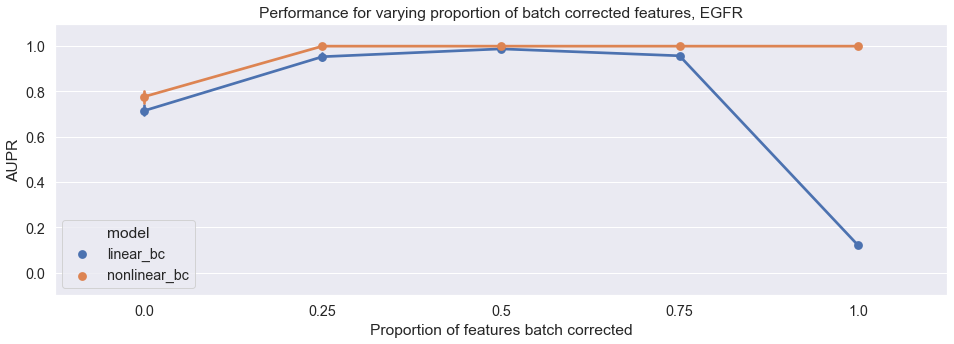

In [50]:
gene = 'EGFR'
plot_df = results_df[
    (results_df.identifier == gene) &
    (results_df.signal == 'signal') &
    (results_df.data_type == 'test')
]

with sns.plotting_context('notebook', font_scale=1.3):
    sns.set({'figure.figsize': (16, 5)})
    sns.set_style('darkgrid')
    sns.pointplot(data=plot_df, x='titration_ratio', y='aupr', hue='model')
    plt.xlabel('Proportion of features batch corrected')
    plt.ylim(-0.1, 1.1)
    plt.ylabel('AUPR')
    plt.title('Performance for varying proportion of batch corrected features, {}'.format(gene))